In [52]:
import os
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from plotnine import *
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [53]:
traces_location = "<directory_with_parquet_traces>"
list_of_workloads = list(map(lambda x: os.path.join(traces_location, x), os.listdir(traces_location)))

In [54]:
name_to_domain_map = {
    "askalon-new": "Scientific",
    "askalon": "Engineering",
    "icpe": "Scientific",
    "lanl": "Scientific",
    "pegasus": "Scientific",
    "workflowhub": "Scientific",
    "two": "Industry",
    "google": "Industry",
    "chronos": "Industry",
    "alibaba": "Industry",
}

trace_has_structural_information = [
    "icpe",
    "askalon",
    "chronos",
    "alibaba",
    "workflowhub",
    "pegasus",
]

In [55]:
spark = (SparkSession.builder
         .master("local[4]")
         .appName("Longitudinal Analysis")
         .config("spark.executor.memory", "8G")
         .config("spark.driver.memory", "2G")
         .getOrCreate())

In [56]:
def read_trace(workload_location):
    return spark.read.parquet(os.path.join(workload_location, "workflows", "schema-1.0"))

In [57]:
def normalize_df(df):
    df.sort_values(df.columns[0], inplace=True)
    df["pdf"] = df["approx_max_concurrent_tasks"] / df["approx_max_concurrent_tasks"].sum()
    df["cdf"] = df["pdf"].cumsum()

In [ ]:
def folder_name_to_domain(folder_name):
    for name, domain in name_to_domain_map.items():
        if str(folder_name).startswith(name): return domain
    raise NotImplementedError("Unknown folder!")

list_of_dfs = []
for workload in list_of_workloads:
    folder_name = str(os.path.basename(os.path.normpath(workload))).lower()
    
    if not any(folder_name.startswith(x) for x in trace_has_structural_information):
        continue
    
    df = read_trace(workload)
    pdf = df.select("approx_max_concurrent_tasks").filter(F.col("approx_max_concurrent_tasks") > 0).toPandas()
    domain = folder_name_to_domain(folder_name)
    pdf["domain"] = domain
    
    normalize_df(pdf)
    list_of_dfs.append(pdf)

workflow_approx_lop_df = pd.concat(list_of_dfs, ignore_index = True)

In [59]:
def normalize_group(gp):
    gp = gp.groupby("approx_max_concurrent_tasks").sum().reset_index()[["approx_max_concurrent_tasks"]]
    normalize_df(gp)
    return gp
workflow_approx_lop_df = workflow_approx_lop_df.groupby("domain").apply(normalize_group).reset_index()

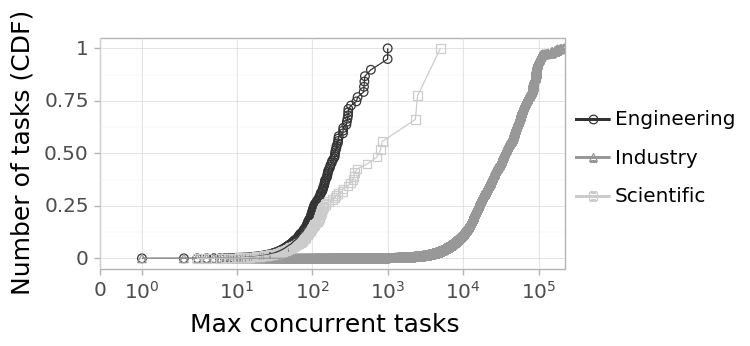

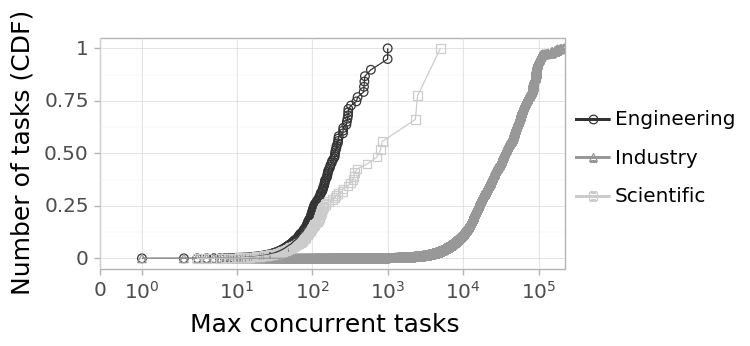

In [64]:
 plt = ggplot(workflow_approx_lop_df) +\
    theme_light(base_size=18) +\
    theme(legend_title=element_text(size=0, alpha=0),
                       legend_box_spacing=0.1,
                       legend_box_margin=0,
                       legend_margin=0,
          legend_position=(1.05, 0.5),
          legend_key=element_blank()) + \
    geom_point(aes(x="approx_max_concurrent_tasks", y="cdf", color="domain", shape="domain"), stat=stat_identity, fill="none", size=3) +\
    geom_line(aes(x="approx_max_concurrent_tasks", y="cdf", color="domain", group="domain"), stat=stat_identity) +\
    scale_color_grey() +\
    xlab("Max concurrent tasks") +\
    ylab("Number of tasks (CDF)")

all_max = workflow_approx_lop_df["approx_max_concurrent_tasks"].max()

fig = plt.draw()
axs = fig.get_axes()
for ax1 in axs:
    ax1.set_xscale('symlog')
    ax1.set_xbound(lower=0, upper=all_max)

fig.set_size_inches(6,3)
fig.savefig("./plots/max_concurrent_tasks_domain_stratified.pdf", bbox_inches='tight')
fig